In [1]:
%reload_ext autoreload
%autoreload 2

In [2]:
import pandas as pd
import sqlite3 as db
import torch
from torch.utils.data import Dataset, DataLoader
import matplotlib.pyplot as plt
from nanoGPT.model import GPT, GPTConfig
from lightning_training import *

from data_process.tokenizers import FullMoveTokenizer

In [3]:
elite_database = db.connect("./data/lichess_elite_database.db")

In [4]:
games_df = pd.read_sql("SELECT * FROM games", elite_database)

In [5]:
games_df

,pgn,piece_uci
0,"[Event ""Rated Blitz game""]\n[Date ""????.??.??""...",Pe2e4 Pe7e5 Ng1f3 Nb8c6 Bf1c4 Bf8c5 Ke1g1 Pd7d...
1,"[Event ""Rated Blitz game""]\n[Date ""????.??.??""...",Pe2e4 Pd7d5 Nb1c3 Pd5e4 Nc3e4 Qd8d5 Qd1f3 Nb8c...
2,"[Event ""Rated Blitz game""]\n[Date ""????.??.??""...",Pe2e4 Pc7c5 Pc2c3 Ng8f6 Pe4e5 Nf6d5 Ng1f3 Nb8c...
3,"[Event ""Rated Blitz game""]\n[Date ""????.??.??""...",Pe2e4 Pd7d5 Pe4d5 Qd8d5 Nb1c3 Qd5a5 Pd2d4 Pc7c...
4,"[Event ""Rated Blitz game""]\n[Date ""????.??.??""...",Pc2c4 Pe7e6 Pg2g3 Pd7d5 Bf1g2 Ng8f6 Ng1f3 Bf8e...
...,...,...
3819125,"[Event ""Rated Classical game""]\n[Date ""????.??...",Pe2e4 Pc7c5 Ng1f3 Pg7g6 Nb1c3 Bf8g7 Pd2d4 Pc5d...
3819126,"[Event ""Rated Blitz game""]\n[Date ""????.??.??""...",Pc2c4 Ng8f6 Nb1c3 Pg7g6 Pe2e4 Bf8g7 Pd2d4 Pd7d...
3819127,"[Event ""Rated Blitz game""]\n[Date ""????.??.??""...",Pd2d4 Ng8f6 Pc2c4 Pd7d6 Nb1c3 Pe7e5 Pe2e4 Nb8d...
3819128,"[Event ""Rated Blitz game""]\n[Date ""????.??.??""...",Pd2d4 Ng8f6 Ng1f3 Pd7d6 Pc2c4 Pg7g6 Nb1c3 Bf8g...


In [6]:
tokenizer = FullMoveTokenizer()

In [7]:
games = list(games_df.piece_uci)

In [8]:
lengths = [len(game.split()) for game in games]

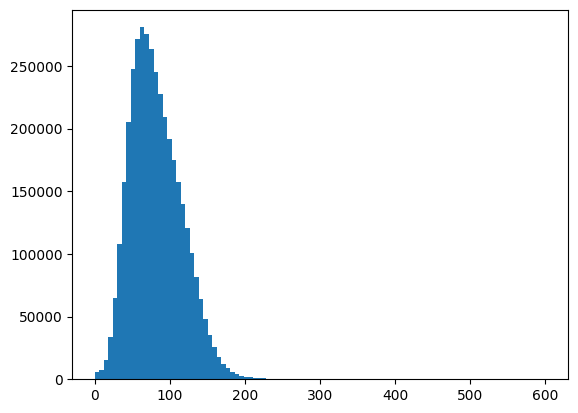

In [9]:
plt.hist(lengths, bins=100)
plt.show()

In [10]:
data_module = GamesDataModule(games)

In [11]:
model_config = GPTConfig(
    block_size=data_module.block_size,
    vocab_size=len(tokenizer.vocab),
    n_layer=3,
    n_head=4,
    n_embd=256,
    bias=False,
)

pl_model = LightningGPT(model_config)

number of parameters: 3.41M


In [12]:
data_module.num_workers = 14

In [13]:
tensorboard_logger = pl.loggers.TensorBoardLogger(save_dir="./lightning_logs", name=f"test_v2")

trainer = pl.Trainer(
    accelerator="gpu",
    max_epochs=2,
    callbacks=[pl.callbacks.RichProgressBar()],
    logger=tensorboard_logger,
    # default_root_dir=
    # fast_dev_run=True
)

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


In [14]:
trainer.fit(
    model=pl_model,
    datamodule=data_module,
    # ckpt_path="../../lightning_logs/sentimate/SentimateNet/version_0/checkpoints/epoch=49-step=536050.ckpt"
    # ckpt_path="../../lightning_logs/sentimate/tensorboard/SentimateNet/version_1/checkpoints/epoch=29-step=321630.ckpt"
)

2024-03-05 19:07:45.954573: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-03-05 19:07:45.954630: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-03-05 19:07:45.955731: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-03-05 19:07:45.961397: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-03-05 19:07:46.735550: W tensorflow/compiler/tf2

┏━━━┳━━━━━━━┳━━━━━━┳━━━━━━━━┓
┃   ┃ Name  ┃ Type ┃ Params ┃
┡━━━╇━━━━━━━╇━━━━━━╇━━━━━━━━┩
│ 0 │ model │ GPT  │  3.5 M │
└───┴───────┴──────┴────────┘

Trainable params: 3.5 M                                                                                            
Non-trainable params: 0                                                                                            
Total params: 3.5 M                                                                                                
Total estimated model params size (MB): 13

Output()

In [ ]:
pl_model.cpu()

output = pl_model.model.generate(torch.tensor([[tokenizer.bos_token_id]], dtype=torch.long), max_new_tokens=30)

In [ ]:
output

tensor([[   1, 3361, 3670, 3685, 3898, 3343, 3886, 3699, 3302, 2815, 3319,  423,
         2993, 3689, 3892, 3443,  425, 2796, 3882, 1884, 3593,  497, 3483, 1919,
         3902, 3536, 3201, 2049, 1790, 2490, 3653]])

In [ ]:
print(tokenizer.decode(output[0].tolist()))

Ng1f3 Ng8f6 Pc2c4 Pe7e6 Nb1c3 Pb7b6 Pg2g3 Bc8b7 Bf1g2 Bf8b4 Ke1g1 Bb4e7 Pd2d4 Pd7d5 Nf3e5 Ke8g8 Bc1e3 Pa7a6 Ra1c1 Nf6e4 Qd1c2 Ne4c3 Rc1c3 Pf7f6 Ne5g4 Bg6d3 Rd2d7 Qd8d7 Rd6a6 Nb8d7
